In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
fs = 30720000

# Read only the PUSCH slots of interest
t0 = 0.0757
T = 10e-3
x = np.fromfile('LTE_uplink_847MHz_2022-01-30_30720ksps.sigmf-data', 'int16',
                offset=int(t0*fs*4), count=int(T*fs*2))

# Scale amplitude so that the PUSCH QPSK symbols are +/-1 +/-1j
x = (x[::2] + 1j*x[1::2])/2e4
# There is no uplink subcarrier at DC in the LTE UL. The central subcarriers
# are at +/-7.5 kHz. Here we shift up by ~6 kHz, in order to move the left central
# subcarrier to DC and take into account a CFO of ~1.5 kHz. The CFO is measured
# with the PUSCH and DMRS.
delta_f = 5.94e3
# Adjust phase offset (done with DMRS signal)
delta_phi = 1.96

x *= np.exp(1j*(2*np.pi*delta_f/fs*np.arange(x.size) + delta_phi))

In [3]:
delta_f - 7.5e3

-1560.0

In [4]:
# The units here are samples
Tu = 2048 # useful time of a symbol
cp_len = 144  # 4.7 usecs, used in symbols 1-6 in a slot
cp_len2 = 160  # 5.2 usecs, used in symbol 0 in a slot

In [5]:
# Poor man's Schmidl & Cox: correlate the end of each symbol with its own cyclic prefix
cp_corr = np.empty(x.size - cp_len - Tu, 'complex64')
for j in range(cp_corr.size):
    cp_corr[j] = np.sum(x[j:][:cp_len] * np.conjugate(x[j+Tu:][:cp_len]))

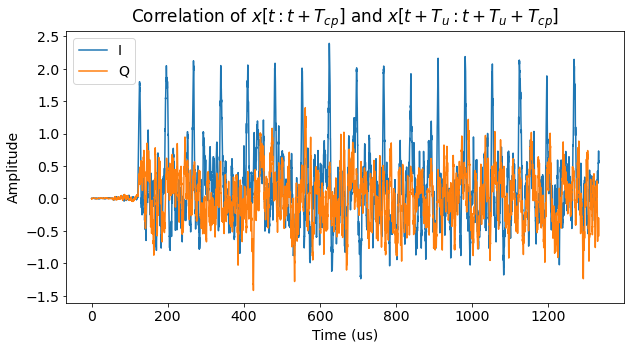

In [6]:
L = 20*Tu
t = np.arange(L)/fs*1e6
plt.plot(t, np.real(cp_corr[:L]))
plt.plot(t, np.imag(cp_corr[:L]))
plt.title('Correlation of $x[t:t+T_{cp}]$ and $x[t+T_u:t+T_u+T_{cp}]$')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.legend(['I', 'Q']);

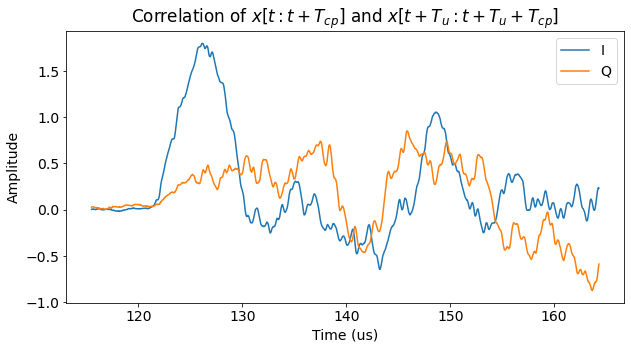

In [7]:
sel = slice(Tu+1500, Tu+3000)
plt.plot(t[sel], np.real(cp_corr[sel]))
plt.plot(t[sel], np.imag(cp_corr[sel]))
plt.title('Correlation of $x[t:t+T_{cp}]$ and $x[t+T_u:t+T_u+T_{cp}]$')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude')
plt.legend(['I', 'Q']);

In [8]:
# a0 is our estimate for the first sample of the first symbol of the first
# slot. On top of that, we add a correction that has been determined with
# the DMRS.
correction = -44
a0 = np.argmax(np.abs(cp_corr[sel])) + sel.start + cp_len2 + correction

In [9]:
slots = 14
nsymbols = slots * 7

# Selection of subcarriers in use
sel_syms = np.arange(905, 1085)

# Here we subtract 7.5 kHz because we have shifted the signal up
# by ~7.5 kHz, since there is no subcarrier at DC (the central carriers
# are at +/- 7.5 kHz).
freq_syms = -7.5e3 + np.fft.fftshift(np.fft.fftfreq(Tu, 1/fs))
freq_syms = freq_syms[sel_syms]

# Extract symbols: PUSCH is handled as SC-OFDM, while DMRS is plain OFDM
symbols = np.empty((nsymbols, sel_syms.size), 'complex64')
for j in range(nsymbols):
    # For each slot, we need to advance cp_len2-cp_len because of the
    # longer cyclic prefix of the first symbol in each slot. delta counts
    # this.
    delta = (cp_len2 - cp_len) * (j//7)
    
    syms = np.fft.fftshift(np.fft.fft(x[a0+j*(Tu+cp_len)+delta:][:Tu]))
    symbols[j] = np.fft.ifft(syms[sel_syms]) if j % 7 != 3 else syms[sel_syms]/np.sqrt(sel_syms.size)

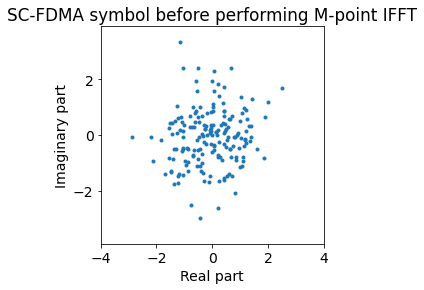

In [10]:
plt.figure(figsize=(4, 4))
s = np.fft.fft(symbols[0])/np.sqrt(symbols[0].size)
plt.plot(s.real, s.imag, '.')
plt.axis('equal')
plt.xlim((-4, 4))
plt.ylim((-4, 4))
plt.title('SC-FDMA symbol before performing M-point IFFT')
plt.ylabel('Imaginary part')
plt.xlabel('Real part');

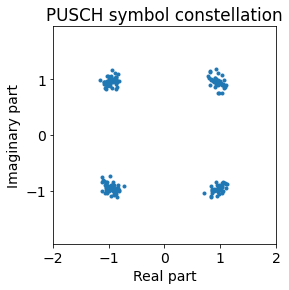

In [11]:
plt.figure(figsize=(4, 4))
plt.plot(symbols[0].real, symbols[0].imag, '.')
plt.axis('equal')
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.title('PUSCH symbol constellation')
plt.ylabel('Imaginary part')
plt.xlabel('Real part');

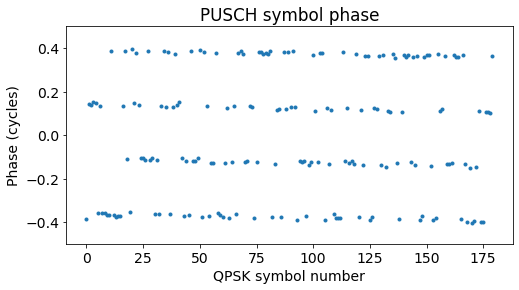

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(np.angle(symbols[0])/(2*np.pi), '.')
plt.ylim((-0.5, 0.5))
plt.title('PUSCH symbol phase')
plt.ylabel('Phase (cycles)')
plt.xlabel('QPSK symbol number');

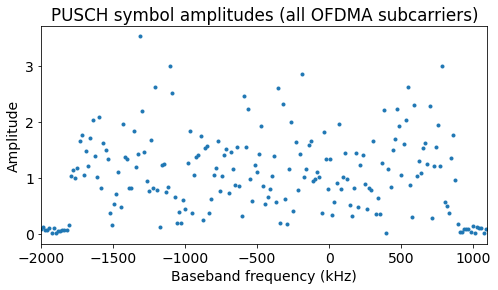

In [13]:
s = np.fft.fftshift(np.fft.fft(x[a0:][:Tu]))/np.sqrt(symbols[0].size)
plt.figure(figsize=(8, 4))
plt.plot((-7.5e3 + np.fft.fftshift(np.fft.fftfreq(Tu, 1/fs)))*1e-3, np.abs(s), '.')
plt.xlim((-2e3, 1.1e3))
plt.title('PUSCH symbol amplitudes (all OFDMA subcarriers)')
plt.ylabel('Amplitude')
plt.xlabel('Baseband frequency (kHz)');

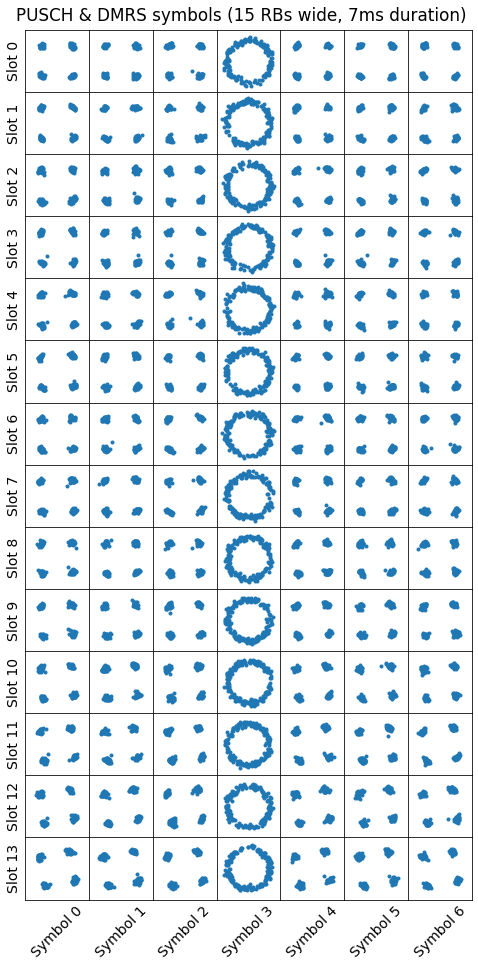

In [14]:
fig, axs = plt.subplots(slots, 7, figsize=(8, 16), facecolor='w', sharex=True, sharey=True)
for j in range(nsymbols):
    slot = j // 7
    sym = j % 7
    ax = axs[slot, sym]
    ax.plot(symbols[j].real, symbols[j].imag, '.')
    ax.set_xlim((-2, 2))
    ax.set_ylim((-2, 2))
    ax.set_xticks([])
    ax.set_yticks([])
    if sym == 0:
        ax.set_ylabel(f'Slot {slot}')
    if slot == axs.shape[0] - 1:
        ax.set_xlabel(f'Symbol {sym}', rotation=45)
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PUSCH & DMRS symbols (15 RBs wide, 7ms duration)', y=0.9);

In [15]:
# Definition of the Zadoff-Chu sequence used for 180 subcarriers (15 RBs).
# With another number of subcarriers, we will need to search for the prime
# N_ZC.
def zadoff_chu(u, v, alpha=0):
    M = 180
    N_ZC = 179  # largest prime < M
    q_ = N_ZC * (u + 1) / 31
    q = int(q_ + 0.5) + v * (-1)**int(2 * q_)
    m = np.arange(N_ZC)
    x_q = np.exp(-1j * np.pi * q * m * (m + 1) / N_ZC)
    n = np.arange(M)
    r_ = x_q[n % N_ZC]
    # we assume delta = 0
    r = np.exp(1j * alpha * n) * r_
    return r

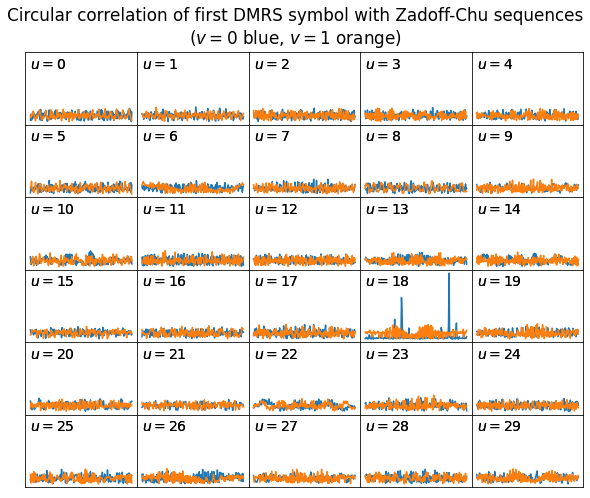

In [16]:
fig, axs = plt.subplots(6, 5, figsize=(10, 8), facecolor='w', sharex=True, sharey=True)
axsr = axs.ravel()
for u in range(30):
    for v in range(2):
        r = zadoff_chu(u, v)
        corr = np.abs(np.fft.ifft(np.fft.fft(symbols[3]) * np.conjugate(np.fft.fft(r))))
        axsr[u].plot(corr)
        axsr[u].text(0, 150, f'$u = {u}$')
        axsr[u].set_yticks([])
        axsr[u].set_xticks([])
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Circular correlation of first DMRS symbol with Zadoff-Chu sequences\n($v = 0$ blue, $v = 1$ orange)',
             y=0.96);

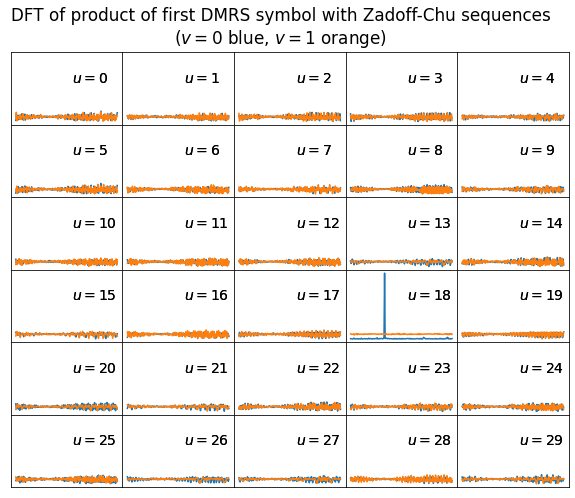

In [17]:
fig, axs = plt.subplots(6, 5, figsize=(10, 8), facecolor='w', sharex=True, sharey=True)
axsr = axs.ravel()
for u in range(30):
    for v in range(2):
        r = zadoff_chu(u, v)
        corr = np.abs(np.fft.fft(symbols[3] * np.conjugate(r)))
        axsr[u].plot(corr)
        axsr[u].text(100, 150, f'$u = {u}$')
        axsr[u].set_yticks([])
        axsr[u].set_xticks([])
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('DFT of product of first DMRS symbol with Zadoff-Chu sequences\n($v = 0$ blue, $v = 1$ orange)',
             y=0.96);

In [18]:
zc_u = 18
zc_v = 0

In [19]:
alphas_ambiguity = np.linspace(-np.pi/2, np.pi/2, 1000)
M = 180
ambiguity = np.empty((alphas_ambiguity.size, M))
zc0 = zadoff_chu(zc_u, zc_v, alpha=0)
zc0f = np.fft.fft(zc0)
for j, alpha in enumerate(alphas_ambiguity):
    zc1 = zadoff_chu(zc_u, zc_v, alpha=alpha)
    ambiguity[j] = np.abs(np.fft.fftshift(np.fft.ifft(zc0f * np.conjugate(np.fft.fft(zc1)))))/M

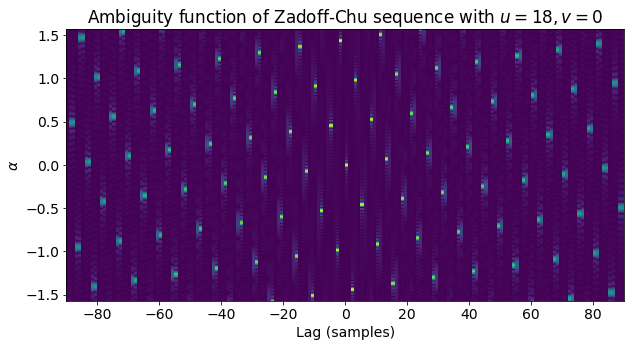

In [20]:
plt.imshow(ambiguity[::-1], interpolation='none', aspect='auto', vmin=0, vmax=1,
           extent=[-M//2, M//2, -np.pi/2, np.pi/2])
plt.ylabel('$\\alpha$')
plt.xlabel('Lag (samples)')
plt.title(f'Ambiguity function of Zadoff-Chu sequence with $u = {zc_u}, v = {zc_v}$');

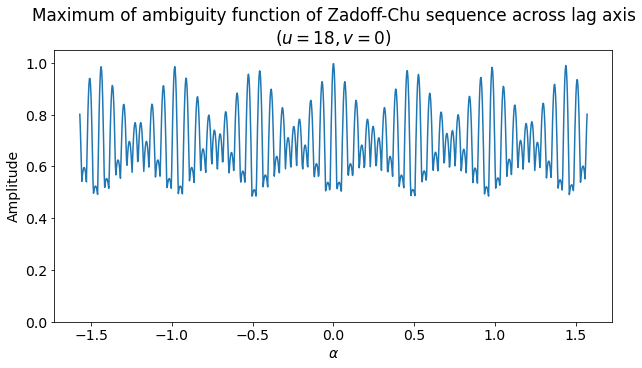

In [21]:
plt.plot(alphas_ambiguity, np.max(ambiguity, axis=1))
plt.ylim((0, 1.05))
plt.title(f'Maximum of ambiguity function of Zadoff-Chu sequence across lag axis\n($u = {zc_u}, v = {zc_v}$)')
plt.ylabel('Amplitude')
plt.xlabel('$\\alpha$');

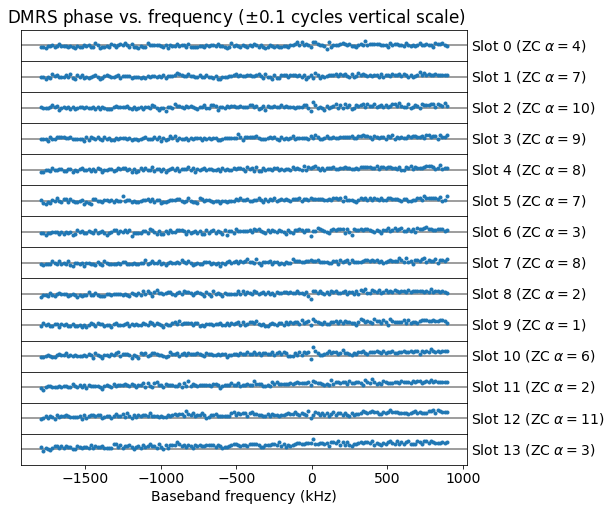

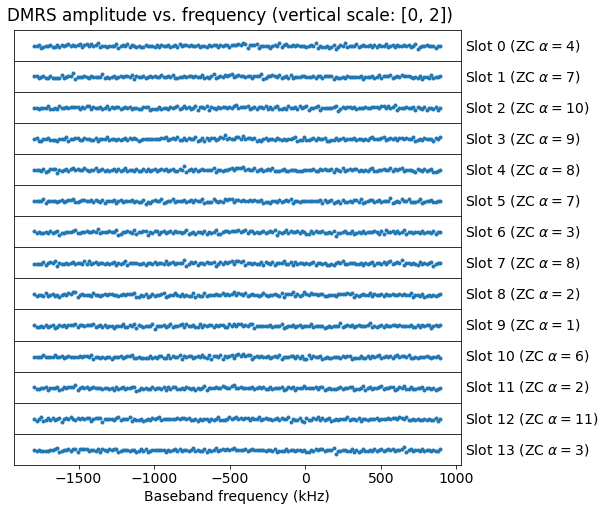

In [22]:
symbols_zc = symbols[3::7]
alphas = np.empty(symbols_zc.shape[0], 'int')
corrs = np.empty(12)
fig, axs = plt.subplots(symbols_zc.shape[0], 1, figsize=(8, 8), facecolor='w', sharex=True)
fig2, axs2 = plt.subplots(symbols_zc.shape[0], 1, figsize=(8, 8), facecolor='w', sharex=True)
fits_phase = np.empty((symbols_zc.shape[0], 2))
fits_amplitude = np.empty(symbols_zc.shape[0])
for n in range(symbols_zc.shape[0]):
    for k in range(12):
        r = zadoff_chu(zc_u, zc_v, alpha=2*np.pi*k/12)
        corrs[k] = np.abs(np.sum(symbols_zc[n] * np.conjugate(r)))
    alphas[n] = np.argmax(corrs)
    syms = (-1)**n * symbols_zc[n] * np.conjugate(zadoff_chu(18, 0, alpha=2*np.pi*alphas[n]/12))
    angle = np.angle(syms)/(2*np.pi)
    fits_phase[n] = np.polyfit(freq_syms, angle, 1)
    fits_amplitude[n] = np.average(np.abs(syms)/np.sqrt(2))
    axs[n].axhline(y=0, color='gray')
    axs[n].plot(freq_syms * 1e-3, angle, '.')
    axs2[n].plot(freq_syms * 1e-3, np.abs(syms)/np.sqrt(2), '.')
    axs[n].set_ylim((-0.1, 0.1))
    axs2[n].set_ylim((0, 2))
    for ax in [axs[n], axs2[n]]:
        ax.set_yticks([])
        ax.yaxis.set_label_position('right')
        ax.set_ylabel(f'Slot {n} (ZC $\\alpha = {alphas[n]}$)',
                      rotation=0, horizontalalignment='left',
                      verticalalignment='center')
for ax in [axs[-1], axs2[-1]]:
    ax.set_xlabel('Baseband frequency (kHz)')
fig.subplots_adjust(hspace=0)
fig2.subplots_adjust(hspace=0)
fig.suptitle('DMRS phase vs. frequency ($\pm 0.1$ cycles vertical scale)', y=0.92);
fig2.suptitle('DMRS amplitude vs. frequency (vertical scale: [0, 2])', y=0.92);

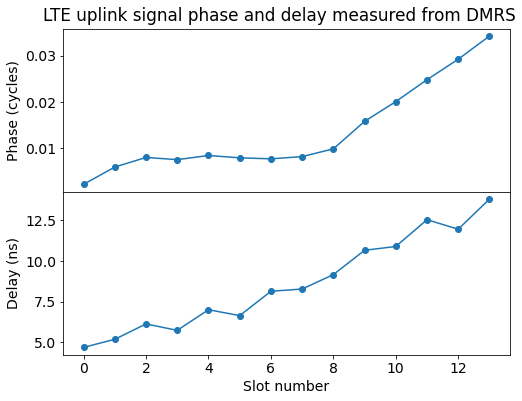

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].plot(fits_phase[:, 1], 'o-')
axs[1].plot(fits_phase[:, 0] * 1e9, 'o-')
axs[0].set_ylabel('Phase (cycles)')
axs[1].set_ylabel('Delay (ns)')
axs[1].set_xlabel('Slot number')
fig.subplots_adjust(hspace=0)
fig.suptitle('LTE uplink signal phase and delay measured from DMRS', y=0.93);

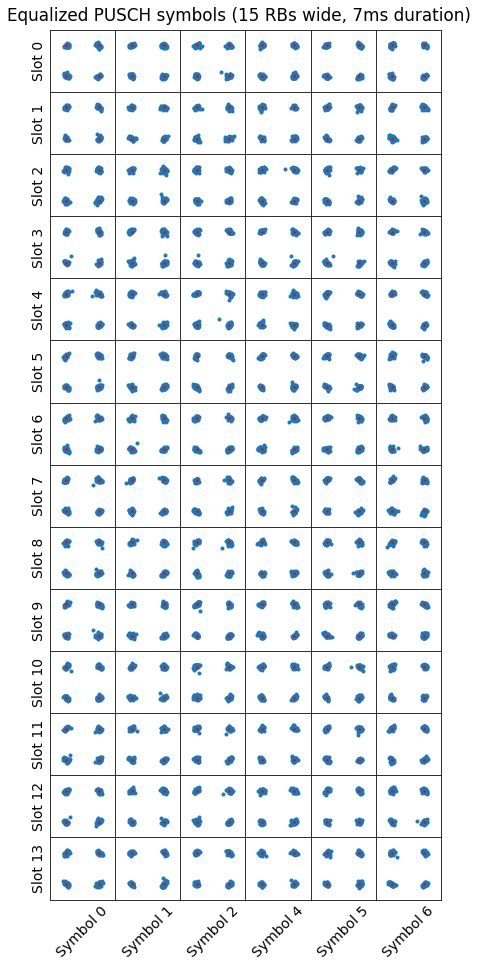

In [24]:
symbols_eq = np.empty((symbols.shape[0]//7*6, symbols.shape[1]), 'complex')
fig, axs = plt.subplots(slots, 6, figsize=(7, 16), facecolor='w', sharex=True, sharey=True)
for j in range(nsymbols):
    slot = j // 7
    sym = j % 7
    if sym == 3:
        continue
    elif sym > 3:
        sym -= 1
    ax = axs[slot, sym]
    k = 6 * slot + sym
    symbols_eq[k] = np.fft.ifft(np.fft.fft(symbols[j])
                            * np.exp(-1j*2*np.pi*np.polyval(fits_phase[slot], freq_syms)))
    symbols_eq[k] /= fits_amplitude[slot]
    ax.plot(symbols_eq[k].real, symbols_eq[k].imag, '.')
    ref = 1j**np.arange(4) * (1 + 1j)
    ax.plot(ref.real, ref.imag, '.', color='red', markersize=3)
    ax.set_xlim((-2, 2))
    ax.set_ylim((-2, 2))
    ax.set_xticks([])
    ax.set_yticks([])
    if sym == 0:
        ax.set_ylabel(f'Slot {slot}')
    if slot == axs.shape[0] - 1:
        ax.set_xlabel(f'Symbol {j % 7}', rotation=45)
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Equalized PUSCH symbols (15 RBs wide, 7ms duration)', y=0.9);

In [25]:
# Calculation of EVM
err = symbols_eq.ravel()[:, np.newaxis] - (1j**np.arange(4) * (1+1j))[np.newaxis, :]
evm = np.sqrt(np.average(np.min(np.abs(err)**2, axis=1)))/np.sqrt(2)
evm, 20*np.log10(evm)

(0.08645338615974534, -21.26435983688337)